In [31]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from commons import remove_symbols, extract_symbols
from collections import Counter

<h2> Skills </h2>
Come prima parte della generazione dei dati, è necessario specificare quali siano le possibili skill che un developer possa avere.


In [32]:
with sqlite3.connect('../datasets/skills_dataset.db') as skills_conn:
    skills_frame = pd.read_sql('SELECT * FROM Skills', skills_conn, index_col='ID') 
skills_frame

,SKILL,TYPE
ID,,
0,JavaScript,Programming Language
1,HTML,Programming Language
2,Python,Programming Language
3,SQL,Programming Language
4,TypeScript,Programming Language
...,...,...
100,Git,Tool
101,Travis,Tool
102,Swift,Programming Language


<h2> Generazione dei profili</h2>
<p> Si passa quindi ad usare un LLM per la generazione dei dati, in particolare GPT 3.5 Turbo</p>
<p> La generazione si svolge in questo modo</p>
<ul>
    <li> Generazione dei linguaggi di programmazione. </li>
    <li> Generazione dei framework. </li>
    <li> Generazione dei dei database conosciuti. </li>
    <li> Generazione dei tools conosciuti. </li>
    <li> Generazione delle piattaforme cloud. </li>
</ul>

<p> Sono state generate 508 tuple. </p>

In [33]:
gpt_generated_frame = pd.read_csv('../datasets/new_gpt_generated_dataset.csv', index_col='ID')

#gpt_generated_frame.drop_duplicates()

gpt_generated_frame


,Linguaggi di Programmazione,Framework,Database,Tools,Cloud
ID,,,,,
1,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Oracle","npm,Webpack,Visual Studio",Heroku
2,"Python,JavaScript","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS
3,"TypeScript,JavaScript,CSS","React,Angular,Vue.js","PostgreSQL,MySQL","Yarn,Webpack,CMake",Google Cloud
4,"Bash,Python","NumPy,PyTorch,Scikit-Learn","MongoDB,Redis","Docker,Pacman,Homebrew",Docker
5,"Java,C++,HTML,CSS,JavaScript","Spring,JavaEE,React,Angular,Vue.js","MySQL,Oracle,Microsoft SQL Server","Maven,Gradle,Kubernetes",Azure
...,...,...,...,...,...
504,"CSS,JavaScript,HTML","React,Angular,Vue.js","MySQL,PostgreSQL","npm,Webpack,Visual Studio",Vercel
505,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Redis","npm,Webpack,Visual Studio",Netlify
506,"Python,JavaScript,CSS","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS


<h2> Esplorazione dei dati Generati </h2>
<p> Si passa ora all'esplorazione dei dati generati. <br> 
Questo avverrà mediante la realizzazione di un barplot circa la frequenza delle skill che compaiono nel dataset, oltre che un boxplot che misuri il numero di skill che compaiono per profilo. <br>
</p>

In [34]:
gpt_generated_frame.rename(columns={
    'Linguaggi di Programmazione': 'progLang',
    'Framework' : 'framework',
    'Database' : 'database',
    'Tools' : 'tools',
    'Cloud' : 'cloud'}, inplace= True)

gpt_generated_frame.describe()

<h3> Considerazioni </h3>
<p> L'analisi per frequenza delle skill del dataset sintetico mostra alcune criticità </p>
<ul>
    <li> Anzitutto un elevato numero di skills risulta non utilizzato </li>
    <li> Alcune skills hanno monopolizzato la generazione, lasciando altre sottorappresentate, ad esempio: </li>
        <ol>
            <li>Vue.js ha monopolizzato la generazione dei framework.</li>
            <li>MongoDB è sovrarappresentato, rispetto a database popolari come Oracle.</li>
            <li>Tutti gli sviluppatori conoscono almeno una piattaforma cloud, non ncessariamente vero.</li>
            <li>Sono stati generati tool non presenti nel dataset delle competenze.</li>
        </ol>
  </li> 

## Pre-Processing dei Dati
Il dataset corrente verrà ristrutturato in modo da avere una rappresentazione omologa a quella presente nel dataset delle offerte, filtrando, al contempo, le skill generate non presenti nel dataset delle skills in uso

In [35]:
developer_frame = pd.DataFrame(columns=['Name', 'Surname', 'Bio', 'Location', 'Languages', 'Skills'])
skills: list[set[str]] = []

skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]
for row in gpt_generated_frame.itertuples():
    raw_skill_set = f'{row.progLang} {row.framework} {row.database} {row.tools} {row.cloud}'
    
    sset = extract_symbols(
        remove_symbols(raw_skill_set),
        list(skills_list)
    )
    skills.append(sset)

developer_frame['Skills'] = skills

developer_frame

,Name,Surname,Bio,Location,Languages,Skills
0,NaN,NaN,NaN,NaN,NaN,"{webpack, react, javascript, mysql, css, herok..."
1,NaN,NaN,NaN,NaN,NaN,"{aws, javascript, python, composer, pip, flask..."
2,NaN,NaN,NaN,NaN,NaN,"{webpack, javascript, google cloud, mysql, cma..."
3,NaN,NaN,NaN,NaN,NaN,"{python, redis, mongodb, docker, bash, pytorch..."
4,NaN,NaN,NaN,NaN,NaN,"{oracle, react, javascript, java, mysql, kuber..."
...,...,...,...,...,...,...
504,NaN,NaN,NaN,NaN,NaN,"{webpack, html, javascript, mysql, css, postgr..."
505,NaN,NaN,NaN,NaN,NaN,"{webpack, react, netlify, javascript, redis, m..."
506,NaN,NaN,NaN,NaN,NaN,"{aws, javascript, python, composer, pip, flask..."
507,NaN,NaN,NaN,NaN,NaN,"{webpack, aws, javascript, mysql, cmake, css, ..."


### Esplorazione dei dati post filtraggio
Si conduce di nuovo la stessa esplorazione eseguita in precedenza, in quanto numerose skills in precedenza rappresentate nel dataset generato sono state rimosse in quanto non supportate dal sistema.

C:\Users\Windows10\AppData\Local\Temp\ipykernel_15952\4258322119.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette='viridis')


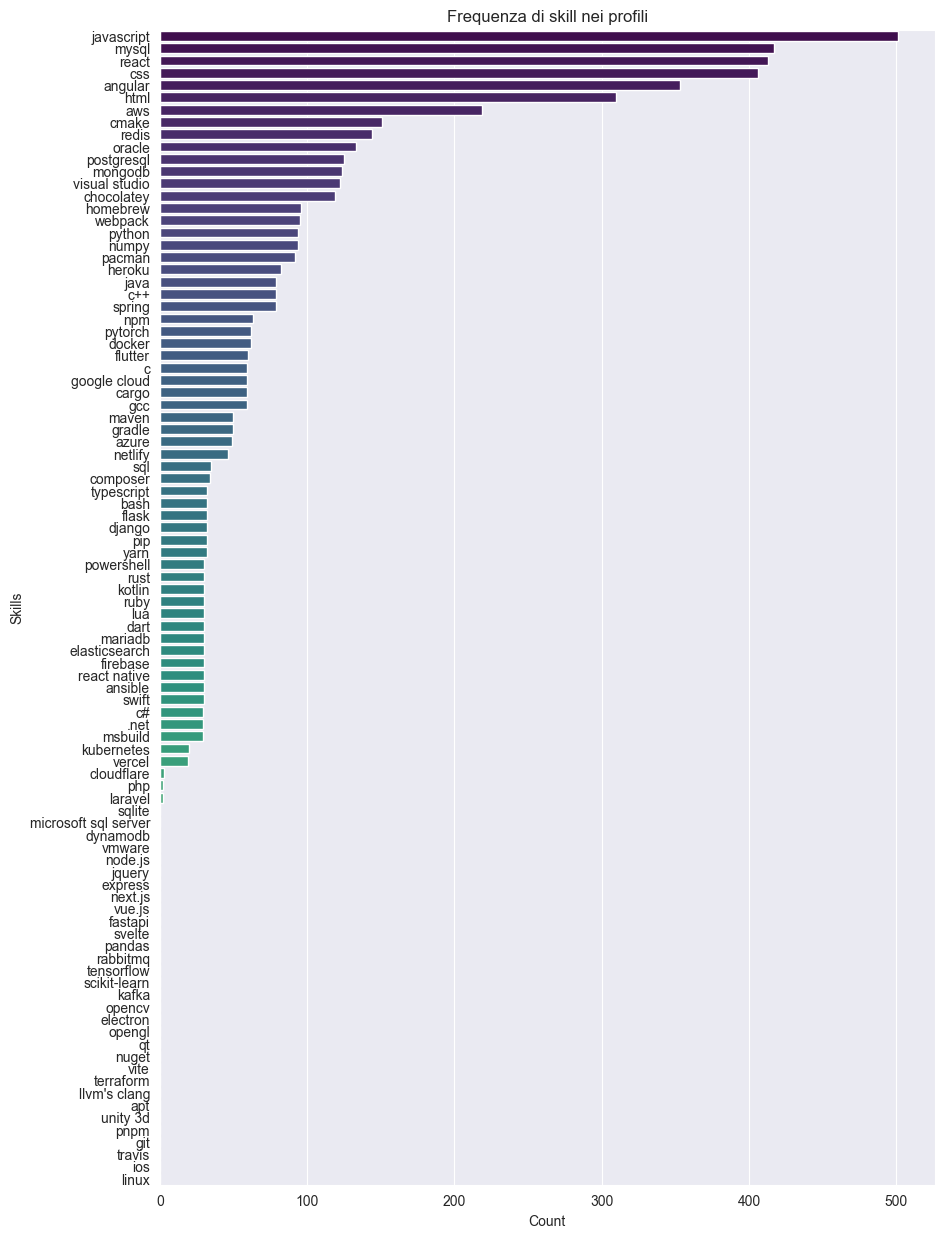

In [36]:
skill_count = Counter()

for skill in skills_list:
    skill_count[skill] = 0

for sset in skills:
    if sset:
        for s in sset:
            skill_count[s] += 1

sorted_counts = {skill: skill_count[skill] for skill in sorted(skill_count, key=skill_count.get, reverse=True)}

plt.figure(figsize=(10, 15))
sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette='viridis')
plt.title("Frequenza di skill nei profili")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()

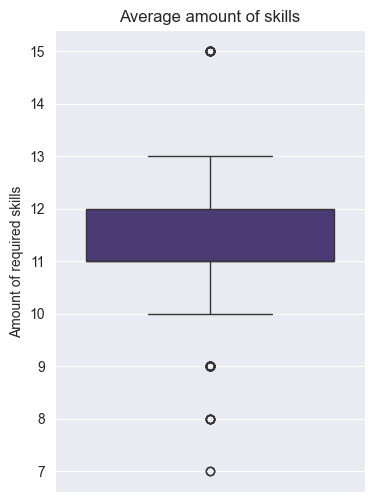

In [37]:
skills_number = []

for sset in skills:
    skills_number.append(len(sset))

plt.figure(figsize=(4, 6))
plt.title("Average amount of skills")
plt.ylabel("Amount of required skills")
sns.boxplot(y=skills_number)
plt.show()

In [38]:
f = []

for sset in skills:
    f.append(len(sset) > 13 or len(sset) < 10)

outliers = developer_frame.loc[f]
outliers

,Name,Surname,Bio,Location,Languages,Skills
3,NaN,NaN,NaN,NaN,NaN,"{python, redis, mongodb, docker, bash, pytorch..."
4,NaN,NaN,NaN,NaN,NaN,"{oracle, react, javascript, java, mysql, kuber..."
8,NaN,NaN,NaN,NaN,NaN,"{aws, javascript, docker, redis, react, mariad..."
9,NaN,NaN,NaN,NaN,NaN,"{aws, python, mongodb, powershell, chocolatey,..."
10,NaN,NaN,NaN,NaN,NaN,"{cargo, javascript, rust, elasticsearch, redis..."
...,...,...,...,...,...,...
459,NaN,NaN,NaN,NaN,NaN,"{oracle, react, javascript, java, mysql, kuber..."
463,NaN,NaN,NaN,NaN,NaN,"{html, javascript, redis, docker, css, heroku,..."
479,NaN,NaN,NaN,NaN,NaN,"{aws, html, javascript, redis, docker, css, re..."
492,NaN,NaN,NaN,NaN,NaN,"{oracle, react, javascript, java, mysql, kuber..."


### Ribilanciamento dei dati
Si è scelto di andare a modificare la frequenza di alcune delle skill presenti nel dataset al fine di farlo aderire di più alla realtà:
In Particolare:
1. Ogni profilo che contiene Vue.js viene ribilanciato per contenere Node.js, jQuery o Express.
2. Ogni profilo che contiene CSS conterrà anche HTML con il 95% della probabilità.
3. Ogni profilo che contiene Redis verrà ribilancaito sostituendolo con Oracle, MySQL e PostgreSQL.
4. Ogni profilo contenente CMAKE verrà ribilanciato inserendo C e C++.
5. Ogni profilo che contiene NumPy verrà ribilanciato inserendo Pandas.
6. Una porzione di profili che contengono React verranno ribilanciati inserendo NextJS.
7. Circa metà dei profili che contengono Python verranno ribilanciati inserendo anche pip.
8. Ogni profilo che contiene Rust verrà ribilanciato inserendo Cargo e viceversa.
9. Circa la metà dei profili che contengono Scikit-Learn verranno ribilanciati inserendo Tensorflow.
10. Verrà aggiunto Git al 90% dei profili.
11. Verrà aggiunto Travis al 25% dei profili che conoscono Git.